In [2]:
source("common.R")

levels <- c("Activity not limited", "Activity limited a little", "Activity limited a lot")

group_levels <- c('4 to <12 weeks', '12 to <26 weeks', '26 to <39 weeks', 
                  '39 to <52 weeks', '52 to <78 weeks', '52+ weeks', 
                  '78 to <104 weeks', '104+ weeks', 'Unknown duration')

df <-
  read_csv("data/tidy_ons_longcovid.csv", show_col_types = F)%>%
  filter(Domain=="Duration since first (suspected) coronavirus infection")%>%
  mutate(`Impact on daily activity` = as.factor(`Impact on daily activity`))%>%
  mutate(`Impact on daily activity` = factor(`Impact on daily activity`, levels = levels))%>%
  mutate(Group = factor(Group, levels = group_levels))%>%
  select(-Domain, -filename)

df%>%
  head

Impact on daily activity,Group,Estimate,Lower 95% confidence limit,Upper 95% confidence limit,Week Ending Date,midpoint_date
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<date>,<date>
Activity not limited,4 to <12 weeks,17,13,21,2023-03-05,2023-02-19
Activity not limited,12 to <26 weeks,25,20,31,2023-03-05,2023-02-19
Activity not limited,26 to <39 weeks,28,23,33,2023-03-05,2023-02-19
Activity not limited,39 to <52 weeks,32,27,38,2023-03-05,2023-02-19
Activity not limited,52 to <78 weeks,104,93,116,2023-03-05,2023-02-19
Activity not limited,78 to <104 weeks,30,23,36,2023-03-05,2023-02-19


In [3]:
group_levels <- levels(as.factor(df$Group))

df_duration <- 
  data.frame(Group = group_levels)%>%
  filter(Group!="Unknown duration")%>%
  mutate(duration.min = as.integer(parse_number(Group)))%>%
  mutate(duration.max = as.integer(str_match(Group, ".+<([0-9]+)")[,2]))%>%
  mutate(duration.avg = as.integer(duration.min + (duration.max-duration.min)/2))%>%
  arrange(duration.min, duration.max)

df_duration

Group,duration.min,duration.max,duration.avg
<chr>,<int>,<int>,<int>
4 to <12 weeks,4,12,8
12 to <26 weeks,12,26,19
26 to <39 weeks,26,39,32
39 to <52 weeks,39,52,45
52 to <78 weeks,52,78,65
52+ weeks,52,NA,NA
78 to <104 weeks,78,104,91
104+ weeks,104,NA,NA


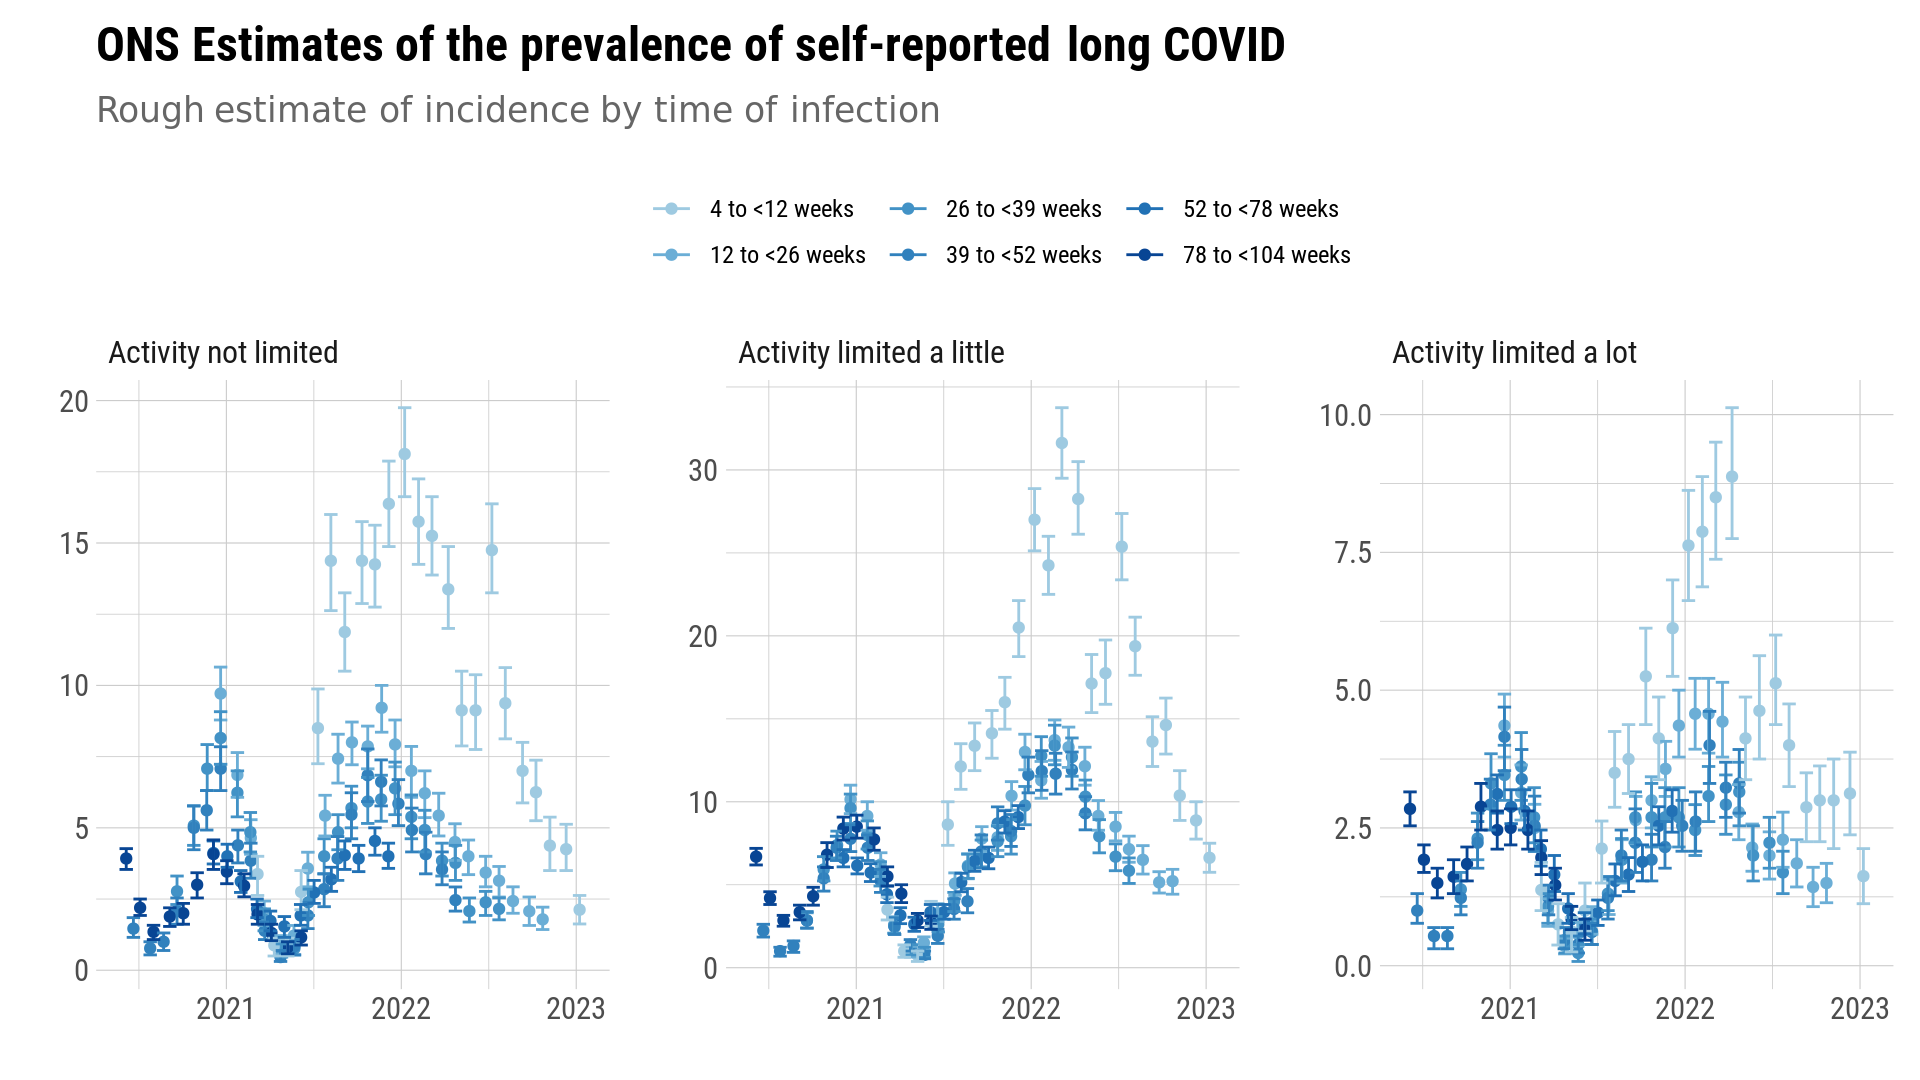

In [4]:
s = 1.25
options(repr.plot.width = s*8, repr.plot.height = s*4.5, repr.plot.res = 240/s)

df%>%
  merge(df_duration)%>%
  filter(!Group %in% c("52+ weeks", "104+ weeks"))%>%
  mutate(duration = duration.max-duration.min)%>%
  mutate(InfectionDate = `Week Ending Date`-duration.avg*7)%>%
  ggplot(aes(x = InfectionDate, y = Estimate/duration, color = Group)) + 
  labs(title = "ONS Estimates of the prevalence of self-reported long COVID",
       subtitle = "Rough estimate of incidence by time of infection",
       color = "", x = "", y = "") +
  geom_point() +
  geom_errorbar(aes(ymin = `Lower 95% confidence limit`/duration,
                    ymax = `Upper 95% confidence limit`/duration), width=28) +
  scale_color_manual(values = tail(pal, 6)) +
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
  scale_y_continuous(labels = scales::comma) +
  facet_wrap(~`Impact on daily activity`, ncol = 3, scale = "free_y") +
  theme(legend.position  = "top") +
  savePlot("ONS_LC_incidence_by_time_of_infection")
